In [14]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import nltk
import re
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from sklearn.externals import joblib
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [15]:
companies = ['nikesupport','xboxsupport','upshelp','comcastcares','amazonhelp','jetblue','americanair',
             'tacobellteam','mcdonalds','kimpton','ihgservice','spotifycares','hiltonhelp','applesupport',
             'microsofthelps','googleplaymusic','scsupport','pandorasupport','hoteltonightcx','dunkindonuts',
             'jackbox','chipotletweets','askpanera','carlsjr','att','tmobilehelp','sprintcare','verizonsupport',
             'boostcare','uscellularcares','alaskaair','virginamerica','virginatlantic','delta','british_airways',
             'southwestair','awssupport','twittersupport','askplaystation','neweggservice','dropboxsupport',
             'hpsupport','atviassist','azuresupport','nortonsupport','dellcares','hulu_support','askrobinhood',
             'officesupport','arbyscares','pearsonsupport','yahoocare','idea_cares','airtel_care','coxhelp',
             'kfc_uki_help','asurioncares','adobecare','glocare','sizehelpteam','airasiasupport','safaricom_care',
             'oppocarein','bofa_help','chasesupport','askciti','ask_wellsfargo','keybank_help','moo','centurylinkhelp',
             'mediatemplehelp','godaddyhelp','postmates_help','doordash_help','airbnbhelp','uber_support','asklyft',
             'askseagate','ask_spectrum','askpaypal','asksalesforce','askvirginmoney','askdsc','askpapajohns','askrbc',
             'askebay','asktigogh','vmucare','askamex','ask_progressive','mtnc_care','askvisa','tesco','sainsburys',
             'walmart','asktarget','morrisons','aldiuk','argoshelpers','greggsofficial','marksandspencer','virgintrains',
             'nationalrailenq','sw_help','londonmidland','gwrhelp','tfl','o2']

## Functions

### Display Topics

In [2]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [3]:
def display_topics2(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])

### Topic Distribution

In [4]:
def topic_distribution(df,model):
    unique_tweets = list(set(df.tweet_id))
    topic_list = []
    for tweet in unique_tweets:
        topic_mean = np.mean(model[df['tweet_id'] == tweet], axis=0)
        #print(max(topic_mean))
        itemindex = np.where(topic_mean==max(topic_mean))
        itemindex = topic_mean.argsort()[-3:][::-1]
        #print (int(itemindex[0]))
        topic_tweet = {"tweet_count":tweet,"tweet_category":int(itemindex[0])}
        topic_list.append(topic_tweet)
    
    topics_df = pd.DataFrame(topic_list) 
    topics_df.head(30)
    topicGroup = topics_df.groupby('tweet_category').tweet_count.count().reset_index()
    topicGroup.sort_values('tweet_count',ascending=False, inplace=True)
    
    return topicGroup

### Stop Words

In [16]:
c = [word.lower() for word in companies]

In [17]:
stop = set(stopwords.words('english')+ \
    ['rt','amp', 'via', 'one', 'around', 'would', 'let', 'could', 'going', 'like', 'get', 'may', 'says', 'say', 'make',
        'based', 'even', 'another', 'completely', 'way', 'find', 'used', 'thing', '2017', 'see', 'need',
        'know','knows', 'think', 'thinks', 'take', 'new', 'day', 'days','https','co','dm','us','look', 'hi','tried'
    'want','send','still','back','hello','using','tried','link','thanks','thank','error','help','please','issue',
    'assistance','support','details','name','address','reply','assist','ijkhelp']+c)


In [18]:
exclude = set(string.punctuation)

In [19]:
lemma = WordNetLemmatizer()

In [20]:
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

### Get Topics

In [21]:
def get_topics(company,k,d,mindf=1,maxdf=1.0,c=companies,stop=stop):
    ''' Takes a company and then runs NMF to get the topics. 
    Returns model and feature names.
    
    Parameters:
    company: str name of company 
    k: int components for nmf
    d: dataframe containing tweets'''
    c = [word.lower() for word in c]
    stop = list(stop)
    stop.extend(c)
    stop = set(stop)
    
    companyDF = d[d['author_id'].str.contains(company) | d['text'].str.contains(company)]
    print('dataframe shape:',companyDF.shape)
    
    func_tf_vectorizer = TfidfVectorizer(stop_words=stop,use_idf=True,token_pattern="\\b[a-z][a-z]+\\b",max_df=maxdf,min_df=mindf)
    func_tf = func_tf_vectorizer.fit_transform(companyDF.text)
    func_tf_feature_names = func_tf_vectorizer.get_feature_names()
    func_nmf = NMF(n_components=k, init='random')
    func_nmf_fit = func_nmf.fit_transform(func_tf)
    
    topic_dist = topic_distribution(companyDF,func_nmf_fit)
    
    return func_nmf,func_tf_feature_names, topic_dist

In [22]:
def multi_get_topics(companyDF,k,mindf=1,maxdf=1.0,c=companies,stop=stop):
    ''' Takes a company and then runs NMF to get the topics. 
    Returns model and feature names.
    
    Parameters:
    company: str name of company 
    k: int components for nmf
    d: dataframe containing tweets'''

    c = [word.lower() for word in c]
    stop = list(stop)
    stop.extend(c)
    stop = set(stop)
    
#     companyDF = d[d['author_id'].str.contains(company) | d['text'].str.contains(company)]
#     print('dataframe shape:',companyDF.shape)
    
    func2_tf_vectorizer = TfidfVectorizer(stop_words=stop,use_idf=True,token_pattern="\\b[a-z][a-z]+\\b",max_df=maxdf,min_df=mindf)
    func2_tf = func2_tf_vectorizer.fit_transform(companyDF.text)
    func2_tf_feature_names = func2_tf_vectorizer.get_feature_names()
    func2_nmf = NMF(n_components=k, init='random')
    func2_nmf_fit = func2_nmf.fit_transform(func2_tf)
    
    topic2_dist = topic_distribution(companyDF,func2_nmf_fit)
    
    return func2_nmf,func2_tf_feature_names, topic2_dist

### Get Industry DataFrame

In [12]:
def get_industry(companylist,data):
    industryDF = pd.DataFrame()
    for company in companylist:
        newDF = data[data['author_id'].str.contains(company) | data['text'].str.contains(company)]
        print(newDF.shape)
        industryDF = industryDF.append(newDF)
        
    return industryDF

### Lemmatize and Tokenize

In [13]:
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

### Process Tweet Text

In [15]:
def process_tweet_text(tweet):
    if tweet.startswith('@null'):
        return "[Tweet not available]"
    tweet = re.sub(r'\$\w*','',tweet) # Remove tickers
    tweet = re.sub(r'https?:\/\/.*\/\w*','',tweet) # Remove hyperlinks
    tweet = re.sub(r'['+string.punctuation+']+', ' ',tweet) # Remove puncutations like 's
    twtok = TweetTokenizer(strip_handles=True, reduce_len=True)
    tokens = twtok.tokenize(tweet)
    tokens = [i.lower() for i in tokens if i not in stop and len(i) > 2 and  
                                             i in english_vocab]
    return ",".join(tokens)

## Import Data

In [16]:
df = pd.read_csv('../data/twcs.csv')

## EDA

In [17]:
df.shape

(2225821, 7)

In [18]:
df.columns.tolist()

['tweet_id',
 'author_id',
 'inbound',
 'created_at',
 'text',
 'response_tweet_id',
 'in_response_to_tweet_id']

In [19]:
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,VirginAtlantic,False,Wed Oct 04 22:37:58 +0000 2017,@95932 Hmmm they may be full. Have you tried b...,2,3.0
1,2,95932,True,Wed Oct 04 22:55:58 +0000 2017,@VirginAtlantic Sure have. Nothing comes up at...,4,1.0
2,4,VirginAtlantic,False,Wed Oct 04 23:00:12 +0000 2017,@95932 I'm going to report this then. It sound...,NaN,2.0
3,3,95932,True,Wed Oct 04 22:36:35 +0000 2017,"@VirginAtlantic Yes, nothing comes up 🙁",1,5.0
4,5,VirginAtlantic,False,Wed Oct 04 20:15:59 +0000 2017,@95932 Have you tried towards the end of March...,3,6.0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225821 entries, 0 to 2225820
Data columns (total 7 columns):
tweet_id                   int64
author_id                  object
inbound                    bool
created_at                 object
text                       object
response_tweet_id          object
in_response_to_tweet_id    float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 104.0+ MB


In [21]:
df['date'] = pd.to_datetime(df.created_at)

In [58]:
df['time'] = df.date.dt.time

In [57]:
df['month'] = df.date.dt.month

In [59]:
df.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date,month,day,time
0,1,VirginAtlantic,False,@95932 Hmmm they may be full. Have you tried b...,2,3.0,2017-10-04 22:37:58,10,2,22:37:58
1,2,95932,True,@VirginAtlantic Sure have. Nothing comes up at...,4,1.0,2017-10-04 22:55:58,10,2,22:55:58
2,4,VirginAtlantic,False,@95932 I'm going to report this then. It sound...,NaN,2.0,2017-10-04 23:00:12,10,2,23:00:12
3,3,95932,True,"@VirginAtlantic Yes, nothing comes up 🙁",1,5.0,2017-10-04 22:36:35,10,2,22:36:35
4,5,VirginAtlantic,False,@95932 Have you tried towards the end of March...,3,6.0,2017-10-04 20:15:59,10,2,20:15:59


In [62]:
df.to_pickle('../data/tweets.pkl')

### Import Pickle

In [68]:
df = pd.read_pickle('../data/tweets.pkl')

### Response Time

Starter code from [Kaggle Dataset](https://www.kaggle.com/soaxelbrooke/first-inbound-and-response-tweets)

In [69]:
# Pick only inbound tweets that aren't in reply to anything...
first_inbound = df[pd.isnull(df.in_response_to_tweet_id) & df.inbound]
print('Found {} first inbound messages.'.format(len(first_inbound)))

Found 622277 first inbound messages.


In [70]:
# Merge in all tweets in response
inbounds_and_outbounds = pd.merge(first_inbound, df, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id')
print("Found {} responses.".format(len(inbounds_and_outbounds)))

Found 696125 responses.


In [71]:
# Filter out cases where reply tweet isn't from company
inbounds_and_outbounds = inbounds_and_outbounds[inbounds_and_outbounds.inbound_y ^ True]

In [72]:
print("Found {} responses from companies.".format(len(inbounds_and_outbounds)))
print("Tweets Preview:")
print(inbounds_and_outbounds)

Found 630633 responses from companies.
Tweets Preview:
       tweet_id_x author_id_x  inbound_x  \
0               6       95932       True   
1               9       95933       True   
2              13       95934       True   
3              16       95935       True   
5              28       95938       True   
7              40       95940       True   
8              45       95941       True   
9              45       95941       True   
10             51       95943       True   
11             56       95944       True   
12             59       95945       True   
13             61       95946       True   
14             68       95947       True   
15             74       95948       True   
16             76       95949       True   
17             78       95950       True   
18             80       95952       True   
19             92       95957       True   
20             94       95958       True   
21             96       95959       True   
22             98    

In [24]:
companyGroup = df.groupby('author_id').inbound.count().reset_index()
companyGroup = companyGroup.loc[companyGroup.iloc[:,0].str.contains(r'(^\D{6})')]
companyGroup.sort_values('author_id',inplace=True)

/home/xavier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [25]:
companies = list(set(companyGroup.author_id))
companies.sort()

In [27]:
companies

['ATVIAssist',
 'AWSSupport',
 'AdobeCare',
 'AirAsiaSupport',
 'AirbnbHelp',
 'AlaskaAir',
 'AldiUK',
 'AmazonHelp',
 'AmericanAir',
 'AppleSupport',
 'ArbysCares',
 'ArgosHelpers',
 'AskAmex',
 'AskCiti',
 'AskDSC',
 'AskLyft',
 'AskPapaJohns',
 'AskPayPal',
 'AskPlayStation',
 'AskRBC',
 'AskRobinhood',
 'AskSeagate',
 'AskTarget',
 'AskTigogh',
 'AskVirginMoney',
 'Ask_Spectrum',
 'Ask_WellsFargo',
 'AskeBay',
 'AsurionCares',
 'AzureSupport',
 'BofA_Help',
 'BoostCare',
 'British_Airways',
 'CarlsJr',
 'CenturyLinkHelp',
 'ChaseSupport',
 'ChipotleTweets',
 'CoxHelp',
 'DellCares',
 'DoorDash_Help',
 'DropboxSupport',
 'DunkinDonuts',
 'GWRHelp',
 'GloCare',
 'GoDaddyHelp',
 'GooglePlayMusic',
 'GreggsOfficial',
 'HPSupport',
 'HiltonHelp',
 'HotelTonightCX',
 'IHGService',
 'JackBox',
 'JetBlue',
 'KFC_UKI_Help',
 'KeyBank_Help',
 'Kimpton',
 'LondonMidland',
 'MTNC_Care',
 'McDonalds',
 'MicrosoftHelps',
 'Morrisons',
 'NeweggService',
 'NikeSupport',
 'NortonSupport',
 'OPPOCar

In [28]:
df.drop('created_at',axis=1,inplace=True)

In [29]:
df.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date
0,1,VirginAtlantic,False,@95932 Hmmm they may be full. Have you tried b...,2,3.0,2017-10-04 22:37:58
1,2,95932,True,@VirginAtlantic Sure have. Nothing comes up at...,4,1.0,2017-10-04 22:55:58
2,4,VirginAtlantic,False,@95932 I'm going to report this then. It sound...,NaN,2.0,2017-10-04 23:00:12
3,3,95932,True,"@VirginAtlantic Yes, nothing comes up 🙁",1,5.0,2017-10-04 22:36:35
4,5,VirginAtlantic,False,@95932 Have you tried towards the end of March...,3,6.0,2017-10-04 20:15:59


### Date Range

In [31]:
df.date.min()

Timestamp('2008-05-08 20:13:59')

In [32]:
df.date.max()

Timestamp('2017-11-21 21:43:02')

In [33]:
df2 = df.sort_values('date',ascending=True)

In [34]:
df2.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date,month
319047,347379,SouthwestAir,False,@17251 Have FUN at the lecture tonight! Tell...,347364,347380.0,2008-05-08 20:13:59,5
319046,347364,183416,True,@SouthwestAir Can you pls enter the HI market ...,"347365,347366,347363,347367,347368,347369,3473...",347379.0,2008-05-08 21:04:16,5
542908,590641,241659,True,KTAR.com - Foreclosures still big problem in V...,590640,NaN,2010-02-16 15:49:47,2
627162,681789,263054,True,@263056 Do you know if Carl's Jr serves lunch ...,681787,NaN,2010-03-31 15:24:29,3
627160,681787,CarlsJr,False,@263054 We serve lunch all day!,681788,681789.0,2010-03-31 16:53:27,3


### Tweets by Month

In [35]:
df.inbound.value_counts()

True     1214604
False    1011217
Name: inbound, dtype: int64

In [36]:
inboundDF = df[df.inbound == True]

In [37]:
inboundDF.shape

(1214604, 8)

In [38]:
monthGroup = df.groupby('month').inbound.count().reset_index()

In [39]:
monthGroup

,month,inbound
0,1,328
1,2,332
2,3,283
3,4,451
4,5,545
5,6,602
6,7,978
7,8,2158
8,9,13049
9,10,1252961


Text(0,0.5,'Inbound Tweets')

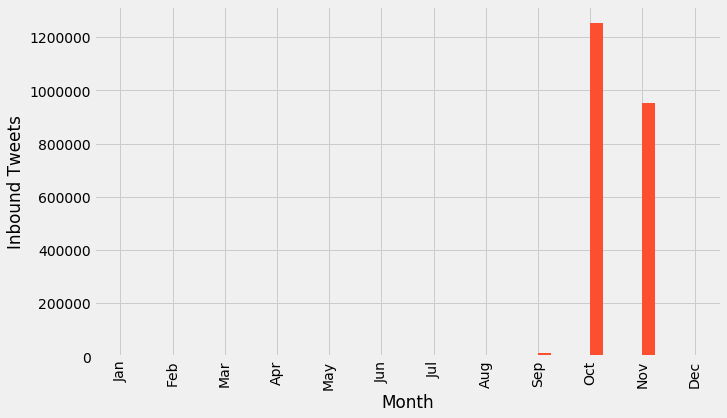

In [40]:
month_ticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monthGroup.plot(kind='bar',figsize=(10,6),legend=False)
plt.xticks(range(12),month_ticks)
plt.xlabel('Month')
plt.ylabel('Inbound Tweets')

### Tweets by Day

In [41]:
df['day'] = df.date.dt.dayofweek

In [42]:
dayGroup = df.groupby('day').inbound.count().reset_index()

Text(0,0.5,'Inbound Tweets')

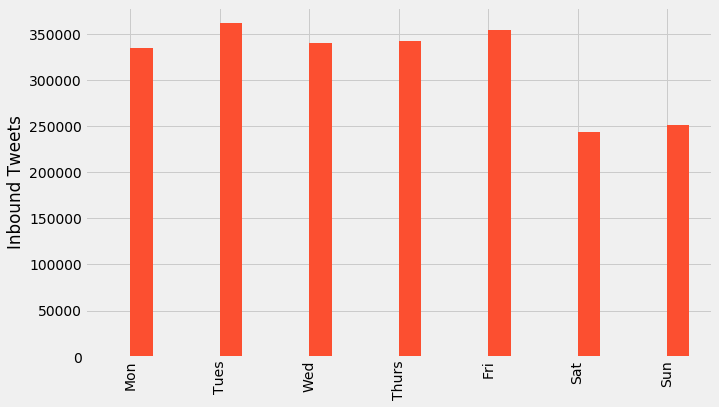

In [43]:
day_ticks = ['Mon','Tues','Wed','Thurs','Fri','Sat','Sun']
dayGroup.plot(kind='bar',figsize=(10,6),legend=False)
plt.xticks(range(7),day_ticks)
#plt.xlabel('Day')
plt.ylabel('Inbound Tweets')

### Tweets by Company

In [44]:
companyGroup = df.groupby('author_id').inbound.count().reset_index()

In [45]:
companyGroup = companyGroup.loc[companyGroup.iloc[:,0].str.contains(r'(^\D{6})')]
companyGroup.sort_values('inbound',ascending=False,inplace=True)

/home/xavier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


In [46]:
companyGroup.shape

(102, 2)

In [47]:
companyGroup

,author_id,inbound
569050,AmazonHelp,129431
569052,AppleSupport,90432
569127,Uber_Support,42289
569119,SpotifyCares,34328
569051,AmericanAir,29642
569120,TMobileHelp,28644
569141,comcastcares,26270
569075,British_Airways,24395
569118,SouthwestAir,23302
569068,Ask_Spectrum,20961


In [48]:
df.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date,month,day
0,1,VirginAtlantic,False,@95932 Hmmm they may be full. Have you tried b...,2,3.0,2017-10-04 22:37:58,10,2
1,2,95932,True,@VirginAtlantic Sure have. Nothing comes up at...,4,1.0,2017-10-04 22:55:58,10,2
2,4,VirginAtlantic,False,@95932 I'm going to report this then. It sound...,NaN,2.0,2017-10-04 23:00:12,10,2
3,3,95932,True,"@VirginAtlantic Yes, nothing comes up 🙁",1,5.0,2017-10-04 22:36:35,10,2
4,5,VirginAtlantic,False,@95932 Have you tried towards the end of March...,3,6.0,2017-10-04 20:15:59,10,2


In [49]:
appleDF = df[df['author_id'].str.contains("AppleSupport") | df['text'].str.contains("AppleSupport") ]

In [50]:
appleDF.shape

(171517, 9)

In [51]:
appleDF.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date,month,day
119,129,AppleSupport,False,@95972 Let's take a look at your flashlight to...,130,131.0,2017-10-04 13:04:26,10,2
120,130,95973,True,@AppleSupport @95972 i have the same problem w...,NaN,129.0,2017-10-04 22:10:17,10,2
309,385,AppleSupport,False,@96035 We want you to get the most out of your...,NaN,386.0,2017-10-04 12:33:00,10,2
339,416,AppleSupport,False,"@96041 We appreciate you letting us know, does...",NaN,417.0,2017-10-04 12:59:29,10,2
340,417,96041,True,@AppleSupport When you go to the App Store &am...,416,418.0,2017-10-04 04:57:54,10,2


### Tweets by Conversations

In [52]:
testDF = df[(df['author_id'].str.contains("95972"))]

In [53]:
testDF.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date,month,day
121,131,95972,True,the update made my fuckin flashlight stop work...,129,NaN,2017-10-04 05:43:36,10,2
366775,398930,195972,True,"@AmazonHelp Si, pero ya no soluciona nada, lo ...",398932,398929.0,2017-10-13 13:12:57,10,4
366777,398933,195972,True,@AmazonHelp No voy a perder más tiempo en esto...,NaN,398932.0,2017-10-13 13:16:54,10,4
366778,398931,195972,True,Gracias por nada @96220 @99212 https://t.co/K2...,398929,NaN,2017-10-13 12:56:40,10,4
758859,701554,295972,True,"@97286 No. Demasiado caro. Lo siento, @97286, ...","822262,822263,822264",701546.0,2017-10-21 17:24:07,10,5


In [54]:
testDF.to_csv('../data/test.csv')

## Text Processing

In [55]:
%time doc_clean = [clean(doc).split() for doc in appleDF.text]  

CPU times: user 11.4 s, sys: 152 ms, total: 11.5 s
Wall time: 11.5 s


In [56]:
doc_clean[-1][:]

['669057',
 'critical',
 'able',
 'charge',
 'iphone',
 'try',
 'step',
 'section',
 'if',
 'alert',
 'accessory',
 'isnt',
 'supported',
 'certified',
 'here',
 'httpstcouqxquyfdn0',
 'doesnt',
 'help',
 'exact',
 'version',
 'io',
 'running',
 'httpstcogdrqu22ypt']

## Quick LDA

In [42]:
import gensim
from gensim import corpora

Slow version of gensim.models.doc2vec is being used


In [57]:
dictionary = corpora.Dictionary(doc_clean)

In [58]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [45]:
lda = gensim.models.ldamodel.LdaModel

In [46]:
%time ldamodel = lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=10)

CPU times: user 20min 18s, sys: 2.02 s, total: 20min 20s
Wall time: 20min 15s


In [47]:
print(ldamodel.print_topics(num_topics=5, num_words=3))

[(0, '0.009*"recently,update,fix,sure,back,device,prior,back" + 0.006*"fix" + 0.004*"happy,help"'), (1, '0.019*"help" + 0.012*"recently,fix,sure,back,device,prior,issue,afterwards,back" + 0.008*"reaching"'), (2, '0.015*"update,assist,issue,yet,please,back,device,update,check" + 0.008*"offer,support,help" + 0.006*"happy,detail,reach"'), (3, '0.044*"work,issue,fixed,future,update" + 0.018*"offer,support,help,preferred,language" + 0.006*"support,available,help"'), (4, '0.007*"continue" + 0.005*"reaching,help" + 0.004*"phone"')]


In [48]:
for topic in ldamodel.show_topics(num_topics=6, formatted=False, num_words=6):
    print("Topic {}: Words: ".format(topic[0]))
    topicwords = [w for (w, val) in topic[1]]
    print(topicwords)

Topic 0: Words: 
['recently,update,fix,sure,back,device,prior,back', 'fix', 'happy,help', 'welcome', 'together', 'reaching,always,happy,help']
Topic 1: Words: 
['help', 'recently,fix,sure,back,device,prior,issue,afterwards,back', 'reaching', 'help,explore,ways,provide,assistance', 'version', 'update,assist,issue,yet,please,back,device,update,latest,version,check']
Topic 2: Words: 
['update,assist,issue,yet,please,back,device,update,check', 'offer,support,help', 'happy,detail,reach', 'reaching,support,love,help,together', 'update', 'happy,assist,version,currently,running,version']
Topic 3: Words: 
['work,issue,fixed,future,update', 'offer,support,help,preferred,language', 'support,available,help', 'sent', 'help,issue', 'help,version']
Topic 4: Words: 
['continue', 'reaching,help', 'phone', 'gather,information,better,country', 'happy', 'still']


In [49]:
joblib.dump(ldamodel, '../models/lda.pkl')

['../models/lda.pkl']

## Multicore LDA

In [67]:
from gensim import corpora, models
mlda = models.LdaMulticore(doc_term_matrix, num_topics=5, id2word = dictionary, passes=10, workers=8)

In [68]:
print(mlda.print_topics(num_topics=5, num_words=3))

[(0, '0.040*"httpstcogdrqu22ypt" + 0.038*"issue" + 0.034*"version"'), (1, '0.068*"applesupport" + 0.038*"i️" + 0.021*"apple"'), (2, '0.096*"applesupport" + 0.021*"phone" + 0.016*"io"'), (3, '0.057*"help" + 0.057*"httpstcogdrqu22ypt" + 0.022*"wed"'), (4, '0.043*"httpstcogdrqu22ypt" + 0.038*"there" + 0.028*"well"')]


In [69]:
for topic in mlda.show_topics(num_topics=6, formatted=False, num_words=6):
    print("Topic {}: Words: ".format(topic[0]))
    topicwords = [w for (w, val) in topic[1]]
    print(topicwords)

Topic 0: Words: 
['httpstcogdrqu22ypt', 'issue', 'version', 'help', 'io', 'work']
Topic 1: Words: 
['applesupport', 'i️', 'apple', 'iphone', 'app', 'music']
Topic 2: Words: 
['applesupport', 'phone', 'io', 'iphone', 'update', 'fix']
Topic 3: Words: 
['help', 'httpstcogdrqu22ypt', 'wed', 'here', 'let', 'you']
Topic 4: Words: 
['httpstcogdrqu22ypt', 'there', 'well', 'io', 'go', 'let']


## LDA with SKLEARN

### Count Vectorizer

In [62]:
cv_vectorizer = CountVectorizer(stop_words=stop)
cv = cv_vectorizer.fit_transform(appleDF.text)
cv_feature_names = cv_vectorizer.get_feature_names()

In [70]:
# lda = LatentDirichletAllocation(n_topics=5, max_iter=10, learning_method='online', learning_offset=50.,random_state=0,n_jobs=-1).fit(cv)

In [ ]:
print(lda.print_topics(num_topics=5, num_words=3))

In [ ]:
for topic in lda.show_topics(num_topics=6, formatted=False, num_words=6):
    print("Topic {}: Words: ".format(topic[0]))
    topicwords = [w for (w, val) in topic[1]]
    print(topicwords)

## Quick NMF

### TF-IDF

In [90]:
tf = TfidfVectorizer(stop_words=stop,use_idf=True,token_pattern="\\b[a-z][a-z]+\\b",max_df=.6,min_df=.05)
x = tf.fit_transform(appleDF.text)
tf_feature_names = tf.get_feature_names()

In [91]:
print(x.shape)

(171517, 14)


In [92]:
nmf = NMF(n_components=5, init='random')
nmf_fit = nmf.fit_transform(x)

In [93]:
joblib.dump(nmf, '../models/nmf.pkl')

['../models/nmf.pkl']

In [94]:
display_topics(nmf,tf_feature_names,6)

Topic 0:
help happy device using version issue
Topic 1:
iphone ios version using device apple
Topic 2:
please happy device apple version using
Topic 3:
phone apple update ios using work
Topic 4:
update issue work software device ios


### Clean Apple Tweets

In [46]:
appleDF['clean'] = appleDF.text.apply(lambda x: process_tweet_text(x))

/home/xavier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [47]:
appleDF.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date,month,day,clean
119,129,AppleSupport,False,@95972 Let's take a look at your flashlight to...,130,131.0,2017-10-04 13:04:26,10,2,"flashlight,together,recently,version,number"
120,130,95973,True,@AppleSupport @95972 i have the same problem w...,NaN,129.0,2017-10-04 22:10:17,10,2,"problem,led,doesnt,work,since"
309,385,AppleSupport,False,@96035 We want you to get the most out of your...,NaN,386.0,2017-10-04 12:33:00,10,2,"happening,specifically"
339,416,AppleSupport,False,"@96041 We appreciate you letting us know, does...",NaN,417.0,2017-10-04 12:59:29,10,2,"appreciate,happen,cellular,data"
340,417,96041,True,@AppleSupport When you go to the App Store &am...,416,418.0,2017-10-04 04:57:54,10,2,"pick,randomly,image,video,sec,play,whole"


In [53]:
tf2 = TfidfVectorizer(stop_words=stop,use_idf=True)
x2 = tf2.fit_transform(appleDF.clean)
tf2_feature_names = tf2.get_feature_names()

In [54]:
no_topics = 5
nmf_model = NMF(n_components=no_topics,init='random').fit(x2)
nmf_W = nmf_model.transform(x2)
nmf_H = nmf_model.components_

In [55]:
display_topics(nmf_model,tf2_feature_names,5)

Topic 0:
help happy support love offer
Topic 1:
fixed future work issue update
Topic 2:
version running happy currently exact
Topic 3:
continue reaching together happy working
Topic 4:
device fix back update phone


In [56]:
documents = list(appleDF.text)

In [57]:
no_top_words = 5
no_top_documents = 2
display_topics2(nmf_H, nmf_W, tf2_feature_names, documents, no_top_words, no_top_documents)

Topic 0:
help happy support love offer
help me pls!! @95974 @AppleSupport https://t.co/rowd3uS2Wa
@427347 We're here to help. Follow the steps here: https://t.co/xXaXeeSRt9 DM us if you have questions. https://t.co/GDrqU22YpT
Topic 1:
fixed future work issue update
@510821 Here’s what you can do to work around the issue until it’s fixed in a future software update: https://t.co/xXaXeeSRt9 https://t.co/GDrqU22YpT
@445073  Here’s what you can do to work around the issue until it’s fixed in a future software update: https://t.co/qODbOsp4wz
Topic 2:
version running happy currently exact
@505168 We'd like to look into this with you. Can you let us know which iOS version you have installed? Send us a DM here: https://t.co/GDrqU2kzhr
@619643 We'd like to look into this with you. Which watchOS version and iPhone are you using your Apple Watch with?
Topic 3:
continue reaching together happy working
@636562 Thank you for reaching out. Please DM us and we will continue from there. https://t.co/GD

## Apple

In [392]:
appleNMF,appleFeatures,appleDist = get_topics('AppleSupport',5,df,maxdf=.6,stop=stop)

dataframe shape: (171517, 8)


In [393]:
display_topics(appleNMF,appleFeatures,6)

Topic 0:
future fixed software work update uqexsrrlxj
Topic 1:
iphone want battery issues ios phone
Topic 2:
ios version gt running device settings
Topic 3:
continue reaching together workaround working meet
Topic 4:
happy started go reach assist experiencing


In [394]:
appleDist

,tweet_category,tweet_count
1,1,76508
4,4,30784
2,2,27083
3,3,21614
0,0,15528


## Microsoft

### Topics

In [388]:
microNMF,microFeatures,microDist = get_topics('MicrosoftHelps',5,df,stop=stop)

dataframe shape: (17303, 8)


In [389]:
display_topics(microNMF,microFeatures,6)

Topic 0:
everything end good working checking experience
Topic 1:
improve survey answering twitter experience quick
Topic 2:
answer desk contact suggest case team
Topic 3:
free feel concern reach follow status
Topic 4:
windows update version changes steps prior


In [390]:
microDist

,tweet_category,tweet_count
4,4,10937
2,2,2644
0,0,1500
3,3,1209
1,1,1013


## Dell

### Topics

In [449]:
dellNMF,dellFeatures,dellDist = get_topics('DellCares',3,df,c=companies,stop=stop)

dataframe shape: (6359, 8)


In [404]:
display_topics(dellNMF,dellFeatures,6)

Topic 0:
tag service system registered owner email
Topic 1:
message direct replied follow responded check
Topic 2:
assist glad review looping order team


In [405]:
dellDist

,tweet_category,tweet_count
2,2,4286
0,0,1276
1,1,797


## HP

In [445]:
hpNMF,hpFeatures,hpDist = get_topics('HPSupport',3,df,maxdf = .4,c=companies,stop=stop)

dataframe shape: (10204, 8)


In [446]:
display_topics(hpNMF,hpFeatures,6)

Topic 0:
click private message better asmita trinity
Topic 1:
hear whether additional resolved yet close
Topic 2:
direct message vinod use susan printer


In [447]:
hpDist

,tweet_category,tweet_count
2,2,6941
0,0,1801
1,1,1462


## Tech DF

In [414]:
techDF = get_industry(techlist,df)

(171517, 8)
(17303, 8)
(6359, 8)
(10204, 8)


In [415]:
techDF.shape

(205383, 8)

In [424]:
techNMF,techFeatures,techDist = multi_get_topics(techDF,10,stop=stop,c=companies)
# (companyDF,k,mdf,c=companies,stop=stop)

In [ ]:
techNMF,techFeatures,techDist = multi_get_topics(techDF,10,)

In [308]:
display_topics(techNMF,techFeatures,6)

Topic 0:
thanks tweeting assistance use issue support
Topic 1:
help hey model issue please click
Topic 2:
reply assist better please click direct
Topic 3:
printer model use print tweeting issue
Topic 4:
back hear please issue still contact
Topic 5:
private click message please thanks better
Topic 6:
hppsdr ijkhelp print still hp message
Topic 7:
link direct message use please assistance
Topic 8:
hp support contact print please hey
Topic 9:
hpprnt hpcswus print message still printer


## Quick Cluster

### Kmeans

In [58]:
#without dimensionality reduction

num_clusters = 5

km = KMeans(n_clusters=num_clusters,init='k-means++',n_init=20,n_jobs=-1,max_iter=100)

%time km.fit(x)

clusters = km.labels_.tolist()

CPU times: user 308 ms, sys: 240 ms, total: 548 ms
Wall time: 7.7 s


In [59]:
joblib.dump(km,  '../models/doc_cluster.pkl')

# km = joblib.load('doc_cluster.pkl')
# clusters = km.labels_.tolist()

['../models/doc_cluster.pkl']

In [60]:
appleClusters = appleDF.copy()
appleClusters['clusters'] = clusters

#frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [61]:
appleClusters.clusters.value_counts()

0    93927
2    24611
1    21735
3    19018
4    12226
Name: clusters, dtype: int64

In [62]:
appleClusters.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date,month,day,clean,clusters
119,129,AppleSupport,False,@95972 Let's take a look at your flashlight to...,130,131.0,2017-10-04 13:04:26,10,2,"flashlight,together,recently,version,number",1
120,130,95973,True,@AppleSupport @95972 i have the same problem w...,NaN,129.0,2017-10-04 22:10:17,10,2,"problem,led,doesnt,work,since",0
309,385,AppleSupport,False,@96035 We want you to get the most out of your...,NaN,386.0,2017-10-04 12:33:00,10,2,"happening,specifically",3
339,416,AppleSupport,False,"@96041 We appreciate you letting us know, does...",NaN,417.0,2017-10-04 12:59:29,10,2,"appreciate,happen,cellular,data",0
340,417,96041,True,@AppleSupport When you go to the App Store &am...,416,418.0,2017-10-04 04:57:54,10,2,"pick,randomly,image,video,sec,play,whole",0


In [107]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()


Top terms per cluster:

Cluster 0 words:

NameError: name 'vocab_frame' is not defined

### Cosine Similarity

In [75]:
# from sklearn.metrics.pairwise import cosine_similarity
# dist = 1 - cosine_similarity(x)

### PCA Before TSNE?

In [80]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(nmf_W)

# df['pca-one'] = pca_result[:,0]
# df['pca-two'] = pca_result[:,1] 
# df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [ 0.32311738  0.25988292  0.17274012]


In [81]:
len(pca_result)

171517

### TSNE

In [67]:
tsne_model = TSNE(n_components=2, random_state=0)
results = tsne_model.fit_transform(nmf_W) 

In [68]:
joblib.dump(tsne_model, '../models/tsne.pkl')

['../models/tsne.pkl']

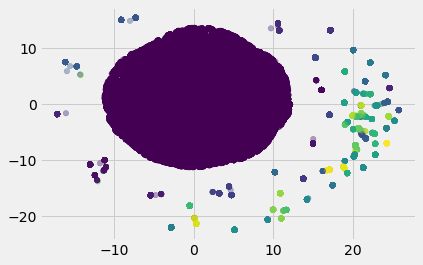

In [69]:
def get_coords(matrix2D):
    x = []
    y = []
    for r in matrix2D:
        x.append(r[0])
        y.append(r[1])
    return x, y

x, y = get_coords(results)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=50, random_state=0).fit(nmf_W)

# Scatter plot with colouring by kmeans labels:
plt.scatter(x, y, alpha=0.4, c=kmeans.labels_, marker='o', s=30);

In [ ]:
joblib.dump(kmeans, '../models/kmeans.pkl')

In [65]:
kmeans = joblib.load('../models/kmeans.pkl')

### TSNE Tech Companies

In [265]:
techlist = ['AppleSupport','MicrosoftHelps','DellCares','HPSupport']

(171517, 8)
(17303, 8)
(6359, 8)
(10204, 8)


In [277]:
techDF.shape

(205383, 8)

In [278]:
tf3_vectorizer = TfidfVectorizer(stop_words=stop,use_idf=True)
tf3 = tf3_vectorizer.fit_transform(techDF.text)
tf3_feature_names = tf3_vectorizer.get_feature_names()

In [281]:
no_topics = 20
nmf2_model = NMF(n_components=no_topics,init='random').fit(tf3)
nmf2_W = nmf2_model.transform(tf3)
nmf2_H = nmf2_model.components_

In [283]:
tsne_tech_model = TSNE(n_components=2, random_state=0)
results = tsne_tech_model.fit_transform(nmf2_W) 

In [284]:
joblib.dump(tsne_tech_model, '../models/tech_tsne.pkl')

['../models/tech_tsne.pkl']

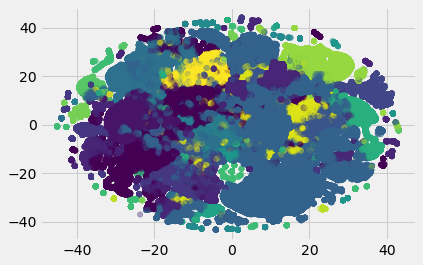

In [285]:
def get_coords(matrix2D):
    x = []
    y = []
    for r in matrix2D:
        x.append(r[0])
        y.append(r[1])
    return x, y

x, y = get_coords(results)

from sklearn.cluster import KMeans
kmeans2 = KMeans(n_clusters=20, random_state=0).fit(nmf2_W)

# Scatter plot with colouring by kmeans labels:
plt.scatter(x, y, alpha=0.4, c=kmeans2.labels_, marker='o', s=30);

In [1]:
mobilelist = ['ATT','TMobileHelp','sprintcare','VerizonSupport','BoostCare','USCellularCares']

In [286]:
musiclist= ['SpotifyCares','PandoraSupport','GooglePlayMusic']

In [287]:
shoppinglist = ['AmazonHelp','AskTarget','Walmart','NeweggService']

In [ ]:
# foodlist = ['Postmates_Help','']

### TSNE 2

In [82]:
tsne_model = TSNE(n_components=2, random_state=0)
results = tsne_model.fit_transform(pca_result) 

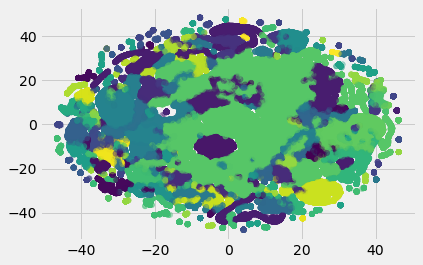

In [83]:
def get_coords(matrix2D):
    x = []
    y = []
    for r in matrix2D:
        x.append(r[0])
        y.append(r[1])
    return x, y

x, y = get_coords(results)


kmeans2 = KMeans(n_clusters=50, random_state=0).fit(pca_result)

# Scatter plot with colouring by kmeans labels:
plt.scatter(x, y, alpha=0.4, c=kmeans2.labels_, marker='o', s=30);

In [ ]:
print(kmeans.labels_)

In [ ]:
labels = kmeans.predict(nmf_H)

In [84]:
joblib.dump(tsne_model, '../models/tsne2.pkl')

['../models/tsne2.pkl']